In [1]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

CUDA not available. Using CPU.


# 1. Train

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
from torch.utils.data import DataLoader, Dataset

file_path = 'disease_symptoms_diagnosis.csv'
df = pd.read_csv(file_path)
df['combined_text'] = df['disease'] + " [SEP] " + df['diagnosis']

train_df, test_df = train_test_split(df, test_size=0.1)

class GPT2Dataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return encoding['input_ids'].squeeze(0), encoding['attention_mask'].squeeze(0)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

MAX_LEN = 256
BATCH_SIZE = 4

train_dataset = GPT2Dataset(train_df['combined_text'].tolist(), tokenizer, MAX_LEN)
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

test_dataset = GPT2Dataset(test_df['combined_text'].tolist(), tokenizer, MAX_LEN)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

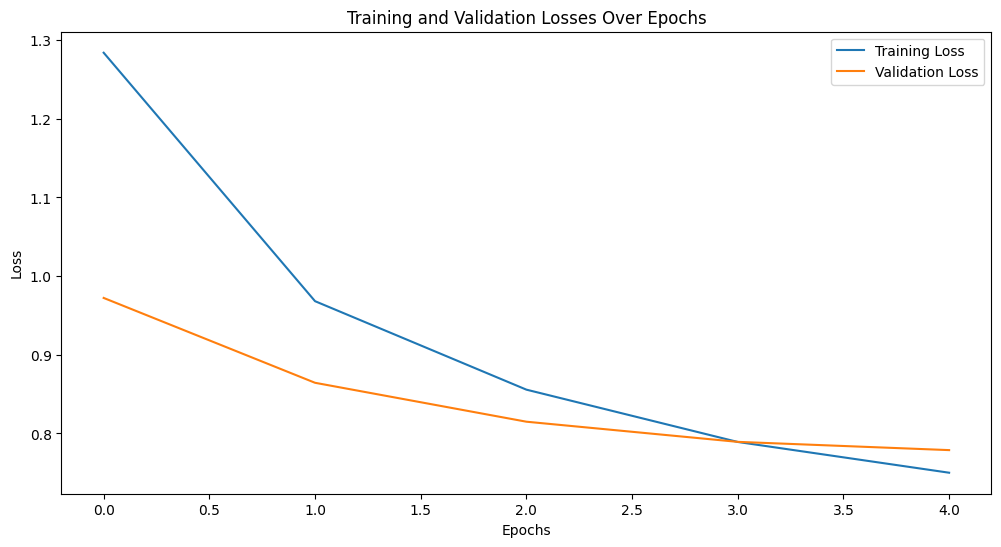

Epoch 5/5, Train Loss: 0.750056282776158, Val Loss: 0.7787893338081164


In [5]:
from transformers import AdamW, get_linear_schedule_with_warmup
from matplotlib import pyplot as plt
from IPython.display import clear_output

model = GPT2LMHeadModel.from_pretrained('gpt2')
model = model.to('cuda')

optimizer = AdamW(model.parameters(), lr=5e-5)
NUM_EPOCHS = 5
total_steps = len(train_data_loader) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    for batch in train_data_loader:
        input_ids, attention_mask = [x.to(device) for x in batch]

        outputs = model(input_ids, labels=input_ids, attention_mask=attention_mask)
        loss = outputs.loss

        total_train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_data_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in test_data_loader:
            input_ids, attention_mask = [x.to(device) for x in batch]

            outputs = model(input_ids, labels=input_ids, attention_mask=attention_mask)
            loss = outputs.loss

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_data_loader)
    val_losses.append(avg_val_loss)

    clear_output(wait=True)
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

torch.save(model.state_dict(), "disease2diagnosis_gpt2_fine-tuned.pth")

# 2. Evaluation

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
from torch.utils.data import DataLoader, Dataset

In [10]:
file_path = 'disease_symptoms_diagnosis.csv'
#file_path = 'SymptomsXanswer-chat.csv'
df = pd.read_csv(file_path)

train_df, test_df = train_test_split(df, test_size=0.1)

In [11]:
test_query = []
test_response = []

for i in range(len(test_df)):
  test_response.append(test_df.iloc[i]['diagnosis'])
  test_query.append(test_df.iloc[i]['disease'])

print(len(test_response))
print(len(test_query))

310
310


In [13]:
test_chatbot = []

# for i in range(len(test_query)):
for i in range(50):
  tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
  tokenizer.pad_token = tokenizer.eos_token

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = GPT2LMHeadModel.from_pretrained('gpt2')
  model_path = 'disease2diagnosis_gpt2_fine-tuned.pth'
  model.load_state_dict(torch.load(model_path, map_location=device))
  model = model.to(device)

  input_text = test_query[i]
  input_ids = tokenizer.encode(input_text, return_tensors='pt')
  attention_mask = torch.ones(input_ids.shape, dtype=torch.long)

  # append the new user input tokens to the chat history
  #bot_input_ids = tokenizer.encode(test_query[i] + tokenizer.eos_token, return_tensors='pt')
  print("{} - Disease: {} \n".format(i, test_query[i]))
  print("{} - Reference:  {} \n".format(i, test_response[i]))

  # generated a response while limiting the total chat history to 1000 tokens,
  chat_history_ids = model.generate(
      input_ids,
      max_length=500,
      pad_token_id=tokenizer.eos_token_id,
      no_repeat_ngram_size=3,
      do_sample=True,
      top_k=10,
      top_p=0.7,
      temperature = 0.8,
      attention_mask=attention_mask,
      num_return_sequences=1
  )

  # pretty print last ouput tokens from bot
  print("{} - Predict: {} \n\n".format(i, tokenizer.decode(chat_history_ids[:, input_ids.shape[-1]:][0], skip_special_tokens=True).strip().replace('[SEP]', '')))
  test_chatbot.append(tokenizer.decode(chat_history_ids[:, input_ids.shape[-1]:][0], skip_special_tokens=True).strip().replace('[SEP]', ''))

print(len(test_chatbot))

0 - Disease: HIV/AIDS 

0 - Reference:  When a patient presents with symptoms of fever, fatigue, sore throat, and skin rash, there are several tests that can be considered to help determine the underlying cause. However, please note that I am not able to diagnose or prescribe specific tests without conducting a physical examination or reviewing your medical history. It is always best to consult with a healthcare professional for an accurate diagnosis and appropriate testing. That being said, some common tests that may be considered in such cases include:  1. Complete Blood Count (CBC): This test can provide information about the overall health of your blood, including the number of white blood cells, red blood cells, and platelets. Abnormalities in these levels can indicate an infection or other underlying conditions.  2. Throat Swab Culture: A swab taken from the back of the throat can be cultured to identify the presence of bacteria, such as streptococcus, which can cause sore throat

In [18]:
df_eval_500 = pd.DataFrame(columns=[test_query[:50], test_response[:50], test_chatbot]).transpose()

In [20]:
df_eval_500.head(1)

,,
HIV/AIDS,"When a patient presents with symptoms of fever, fatigue, sore throat, and skin rash, there are several tests that can be considered to help determine the underlying cause. However, please note that I am not able to diagnose or prescribe specific tests without conducting a physical examination or reviewing your medical history. It is always best to consult with a healthcare professional for an accurate diagnosis and appropriate testing. That being said, some common tests that may be considered in such cases include: 1. Complete Blood Count (CBC): This test can provide information about the overall health of your blood, including the number of white blood cells, red blood cells, and platelets. Abnormalities in these levels can indicate an infection or other underlying conditions. 2. Throat Swab Culture: A swab taken from the back of the throat can be cultured to identify the presence of bacteria, such as streptococcus, which can cause sore throat and fever. 3. Skin Biopsy: If the skin rash is persistent or unusual, a small sample of skin may be taken for examination under a microscope. This can help identify the cause of the rash, such as an infection or autoimmune condition. 4. Viral Panel: This test can detect the presence of viral infections, which can cause symptoms like fever, fatigue, sore throat, and rash. It can help identify specific viruses, such as Epstein-Barr virus or cytomegalovirus. 5. Allergy Testing: In some cases, an allergic reaction can cause symptoms similar to those described. Allergy testing, such as skin prick tests or blood tests, can help identify potential allergens that may be triggering the symptoms. Remember, these are just some of the possible tests that may be considered. The specific tests recommended will depend on your individual symptoms, medical history, and physical examination findings. It is important to consult with a healthcare professional for a proper evaluation and diagnosis.","I'm sorry to hear that you're experiencing fatigue and fatigue-related symptoms. While I can't provide a definitive diagnosis without a physical examination and further tests, I can suggest some tests that may be helpful in determining the underlying cause of your symptoms. These tests can help in identifying the specific infection or inflammation causing your symptoms: 1. Complete Blood Count (CBC): This test can provide information about your red blood cell count, hemoglobin levels, and other parameters that may indicate anemia. 2. Throat Swab Culture: A throat swab can be taken to check for the presence of bacteria, viruses, or fungi that may have been causing your fatigue. 3. Skin Biopsy: If the skin rash is persistent or concerning, a small sample of the affected skin may be taken for examination under a microscope to determine the cause. 4. Viral Panel: A viral panel can help identify the presence and severity of specific viral infections, such as influenza or Epstein-Barr virus. 5. Skin Imaging: In some cases, a skin biopsy may be recommended to examine the skin tissue under a magnifying instrument to detect any abnormalities, such a mole or nodule. 6. Imaging Tests: Depending on your specific symptoms and medical history, your doctor may recommend imaging tests such as a CT scan or MRI to evaluate the organs in your abdomen and rule out any structural abnormalities. It's important to consult with a healthcare professional who can evaluate your symptoms, perform a physical, and order the appropriate tests based on your individual case."


In [24]:
df_eval_500.to_csv('eval_500.csv')

In [23]:
import evaluate

In [36]:
eval_df = pd.read_csv('eval_500.csv')
predictions = eval_df.iloc[2]
references = eval_df.iloc[1]

In [37]:
perplexity = evaluate.load("perplexity", module_type="metric")
results = perplexity.compute(predictions=predictions, model_id='gpt2')
print(results)

  0%|          | 0/1 [00:00<?, ?it/s]

{'perplexities': [404.5300598144531, 8.472825050354004, 9.413199424743652], 'mean_perplexity': 140.80536142985025}


In [32]:
rouge = evaluate.load('rouge')
results = rouge.compute(predictions=predictions, references=references)
print(results)

{'rouge1': 0.26330054354247895, 'rouge2': 0.11018418080359638, 'rougeL': 0.1553047087321281, 'rougeLsum': 0.1553047087321281}


In [33]:
bleu = evaluate.load("bleu")
results = bleu.compute(predictions=predictions, references=references)
print(results)

{'bleu': 0.11926753810203741, 'precisions': [0.39763779527559057, 0.15247524752475247, 0.07569721115537849, 0.04408817635270541], 'brevity_penalty': 1.0, 'length_ratio': 1.1115973741794312, 'translation_length': 508, 'reference_length': 457}


In [34]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.translate.nist_score import sentence_nist
from nltk.tokenize import word_tokenize

def get_metrics(pred, target):
    turns = len(target)
    bleu_2 = 0
    bleu_4 = 0
    meteor = 0
    nist_2 = 0
    nist_4 = 0
    for index in range(turns):
        pred_utt = pred[index]
        target_utt = target[index]
        min_len = min(len(pred_utt), len(target_utt))
        lens = min(min_len, 4)
        if lens == 0:
            continue
        if lens >= 4:
            bleu_4_utt = sentence_bleu([target_utt], pred_utt, weights = (0.25, 0.25, 0.25, 0.25), smoothing_function = SmoothingFunction().method1)
            nist_4_utt = sentence_nist([target_utt], pred_utt, 4)
        else:
            bleu_4_utt = 0
            nist_4_utt = 0
        if lens >= 2:
            bleu_2_utt = sentence_bleu([target_utt], pred_utt, weights = (0.5, 0.5), smoothing_function = SmoothingFunction().method1)
            nist_2_utt = sentence_nist([target_utt], pred_utt, 2)
        else:
            bleu_2_utt = 0
            nist_2_utt = 0
            
        bleu_2 += bleu_2_utt
        bleu_4 += bleu_4_utt
        meteor += meteor_score([word_tokenize(target_utt)], word_tokenize(pred_utt))
        nist_2 += nist_2_utt
        nist_4 += nist_4_utt
        
    bleu_2 /= turns
    bleu_4 /= turns
    meteor /= turns
    nist_2 /= turns
    nist_4 /= turns
    return bleu_2, bleu_4, meteor, nist_2, nist_4


In [35]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

bleu_2, bleu_4, meteor, nist_2, nist_4 = get_metrics(predictions, references)
bleu_2, bleu_4, meteor, nist_2, nist_4

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


(0.42190474661457844,
 0.27602982778663715,
 0.20784642653506857,
 2.9281432200936934,
 3.3407243044381723)